In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11078771575585279595,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3274168854785351219
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [30]:
train_batches = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(directory=train_path, target_size=(260,260),classes=['Fake','Real'],batch_size=10) 
valid_batches = ImageDataGenerator(rescale=1.255)\
                .flow_from_directory(directory=valid_path, target_size=(260,260),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(directory=test_path, target_size=(260,260),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [31]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [32]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
imgs, labels =next(train_batches)

In [34]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

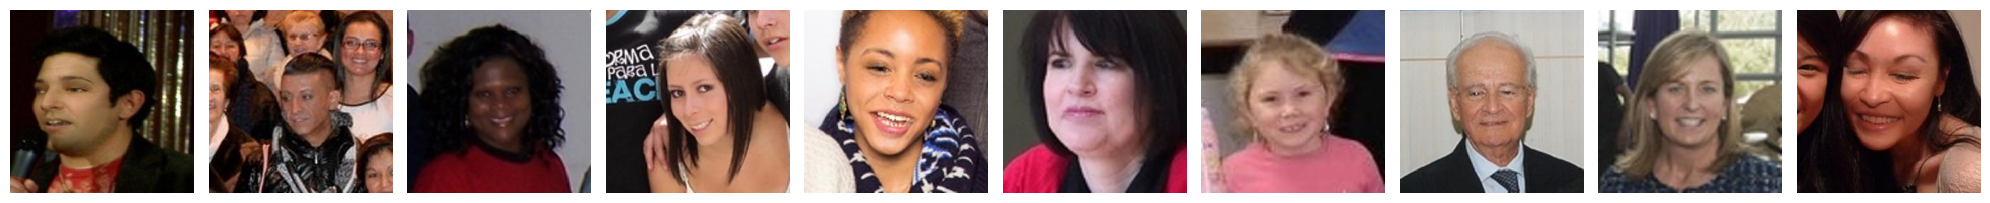

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [35]:
plotImages(imgs)
print(labels)

In [52]:
from tensorflow.keras.applications import EfficientNetB2
def build_model(input_shape=(256, 256, 3), num_classes=2, learning_rate=1e-4):
    # Create the base model
    base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [53]:
model.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 260, 260, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 260, 260, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 261, 261, 3)  0           normalization_5[0][0]            
_____________________________________________________________________________________

In [58]:
from tensorflow.keras.optimizers import Adam


In [37]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [59]:
model = build_model()

D:\anaconda3\envs\tff-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [60]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
14001/14001 [==============================] - 1873s 133ms/step - loss: 0.6979 - accuracy: 0.4989 - val_loss: 2.9196 - val_accuracy: 0.5206
Epoch 2/10
14001/14001 [==============================] - 1669s 119ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 3.5971 - val_accuracy: 0.5194
Epoch 3/10
14001/14001 [==============================] - 1640s 117ms/step - loss: 0.6931 - accuracy: 0.4985 - val_loss: 3.3897 - val_accuracy: 0.5209
Epoch 4/10
14001/14001 [==============================] - 1629s 116ms/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 3.9564 - val_accuracy: 0.5212
Epoch 5/10
14001/14001 [==============================] - 1624s 116ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 3.9573 - val_accuracy: 0.5213
Epoch 6/10
14001/14001 [==============================] - 1625s 116ms/step - loss: 0.6931 - accuracy: 0.4981 - val_loss: 3.9789 - val_accuracy: 0.5214
Epoch 7/10
14001/14001 [==============================] - 1582s 113ms/step - loss: 0.6931 - ac

In [61]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

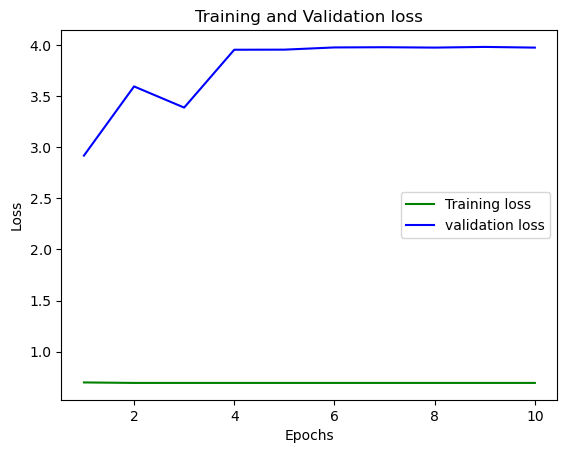

In [62]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

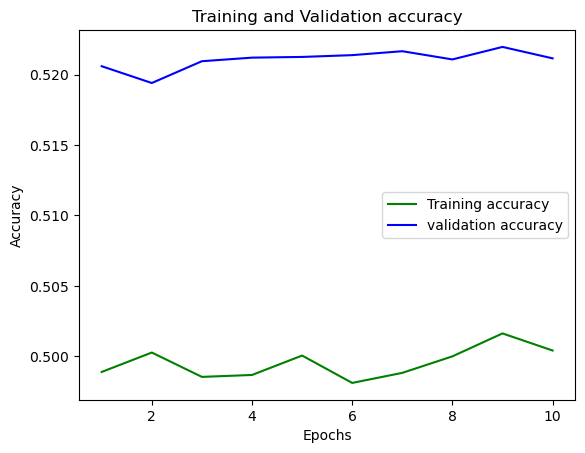

In [64]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
model.metrics_names

['loss', 'accuracy']

In [66]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 139s 124ms/step


In [67]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [68]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [69]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [70]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[5492    0]
 [5413    0]]


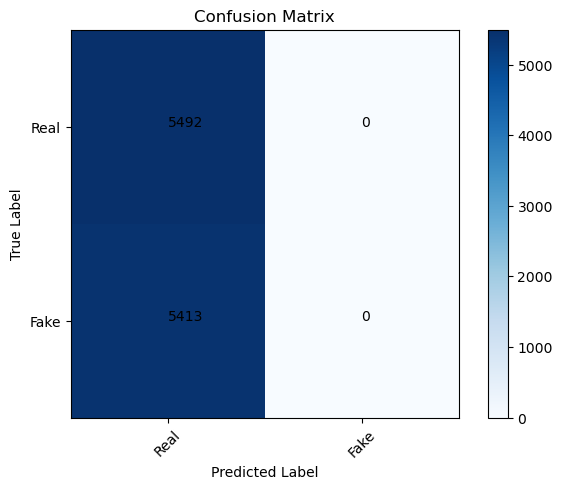

In [71]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [ ]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\DF.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [30]:
#classification_report(test_batches.classes , np.round(predictions))